In [1]:
import os
os.chdir("..")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel(os.path.join("ratio_analysis_plots", "d_processed.xlsx"))

In [3]:
data

,dataset,ml_name,method,lambda,k,Avg.e^2
0,adult,KNN,mean_v1,14.569371,1.933125e-06,0.424207
1,adult,KNN,mean_v2,-3.832102,3.892365e+00,0.332409
2,adult,KNN,similar_v1,6.629730,1.111963e-03,0.147048
3,adult,KNN,similar_v2,5.332352,2.483361e-03,0.241792
4,adult,KNN,multi_v1,5.095211,3.511095e-03,0.090114
...,...,...,...,...,...,...
211,bank,MLP,mean_v2,-8.510056,7.599501e+01,0.556829
212,bank,MLP,similar_v1,-0.694158,6.901930e-02,0.452284
213,bank,MLP,similar_v2,-7.076779,1.754112e+01,0.527676
214,bank,MLP,multi_v1,18.064996,4.123700e-09,0.623496


### Analysis of Output  
Dataset is the major factor of exponential curve fit and curve steepness

#### Groupby ML

In [4]:
data.groupby("ml_name").agg({'Avg.e^2':'median'}).sort_values(by="Avg.e^2")

,Avg.e^2
ml_name,
LinearSVC,0.325652
LogReg,0.325905
KNN,0.387774
MLP,0.403259
Tree,0.417961
Forest,0.423837


In [5]:
data.groupby("ml_name").agg({'lambda':'median'}).sort_values(by="lambda")

,lambda
ml_name,
KNN,0.353970
LogReg,0.384772
LinearSVC,0.600193
MLP,1.727437
Tree,1.897911
Forest,3.016339


#### Groupby Dataset

In [6]:
data.groupby("dataset").agg({'Avg.e^2':'median'}).sort_values(by="Avg.e^2")

,Avg.e^2
dataset,
compas,0.148974
adult,0.247918
communities,0.340193
titanic,0.448134
german,0.481169
bank,0.515395


In [7]:
data.groupby("dataset").agg({'lambda':'median'}).sort_values(by="lambda")

,lambda
dataset,
titanic,-1.184967
bank,-0.785825
german,-0.611679
communities,2.770809
adult,5.719160
compas,6.417708


#### Groupby Imputation Method

In [8]:
data.groupby("method").agg({'Avg.e^2':'median'}).sort_values(by="Avg.e^2")

,Avg.e^2
method,
similar_v1,0.273038
multi_v1,0.280543
multi_v2,0.370827
mean_v1,0.406623
similar_v2,0.421221
mean_v2,0.470482


In [9]:
data.groupby("method").agg({'lambda':'median'}).sort_values(by="lambda")

,lambda
method,
mean_v2,-0.593358
similar_v2,0.539437
similar_v1,2.004557
multi_v1,2.121350
mean_v1,2.244799
multi_v2,2.481914


### Analysis of Datasets  
1. Correlation to the protected attribute can affect the initial bias, but not related to curve steepness

In [10]:
from utils.data import create_adult_dataset, create_bank_dataset
from utils.data import create_communities_dataset, create_compas_dataset
from utils.data import create_german_dataset, create_titanic_dataset
from sklearn.preprocessing import LabelEncoder

In [11]:
def drop_na(data):
    data = data.copy()
    tmp_concat = pd.concat([data.X, pd.DataFrame(data.y, columns=["_TARGET_"])], axis=1)
    tmp_concat.dropna(inplace=True)
    tmp_concat.reset_index(drop=True, inplace=True)
    data.X = tmp_concat.drop(columns=["_TARGET_"]).copy()
    data.y = tmp_concat["_TARGET_"].copy().to_numpy().ravel()
    return data

In [12]:
def convert_protected(data):
    data = data.copy()
    encoder = LabelEncoder()
    for feature in data.protected_features:
        data.X[feature] = encoder.fit_transform(data.X[feature])
    return data, encoder

In [13]:
def concat(data):
    data = data.copy()
    return pd.concat([data.X, pd.DataFrame(data.y, columns=["_TARGET_"])], axis=1)

In [14]:
def clf_evaluate(X, y):
    import warnings
    warnings.filterwarnings('ignore')
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.preprocessing import StandardScaler
    from sklearn.svm import LinearSVC
    from imblearn.over_sampling import SMOTE
    smote = SMOTE()
    X_res, y_res = smote.fit_resample(X, y)
    clf = {
        "Logistic Regression": LogisticRegression,
        "Decision Tree": DecisionTreeClassifier,
        "Random Forest": RandomForestClassifier,
        "K-Nearest Neighbors": KNeighborsClassifier,
        "Linear SVM": LinearSVC,
    }
    result = {}
    scaler = StandardScaler()
    scaler.fit(X_res)
    best_score = 0.0
    best_clf = ""
    for name, model_fn in clf.items():
        score = 0.0
        kf = StratifiedShuffleSplit(n_splits=5)
        for train_idx, test_idx in kf.split(X_res, y_res):
            X_train, X_test = X_res[train_idx], X_res[test_idx]
            y_train, y_test = y_res[train_idx], y_res[test_idx]
            model = model_fn()
            model.fit(scaler.transform(X_train), y_train)
            score += model.score(scaler.transform(X_test), y_test)
        score /= 5
        if score > best_score:
            best_clf = name
            best_score = score
    return (best_clf, best_score)

In [15]:
def analysis_report(data_fn, lr_data):
    data = data_fn()
    assert len(data.protected_features) > 0
    data = drop_na(data)
    data, encoder = convert_protected(data)
    cdata = concat(data)

    print("Dataset Name: {:<20} {} features, {} rows".format(data.name, data.X.shape[1], data.X.shape[0]))
    print()

    print("Target Value Distribution:")
    for key, val in cdata["_TARGET_"].value_counts().items():
        print("\tValue: {:<20} Percent: {:.4f}%".format(key, val/cdata.shape[0]))
    print()
        
    print("Protected Attribute: {}".format(data.protected_features[0], encoder.classes_))
    print("Protected Value Distribution:")
    for key, val in cdata[data.protected_features[0]].value_counts().items():
        print("\tValue: {:<20} Percent: {:.4f}%".format(encoder.inverse_transform([key])[0], val/cdata.shape[0]))
    print()
        
    print("Correlations with Target:")
    corr = cdata.corr()
    for key, val in corr["_TARGET_"][corr["_TARGET_"].abs().sort_values(ascending=False).head(20).index].items():
        print("\tFeature: {:<30} Corr: {:.4f}".format(key, val))
    print()

    print("Correlations with Protected:")
    for key, val in corr[data.protected_features[0]][corr[data.protected_features[0]].abs().sort_values(ascending=False).head(20).index].items():
        print("\tFeature: {:<30} Corr: {:.4f}".format(key, val))
    print()

    most_correlated_features = corr[data.protected_features[0]].copy()
    most_correlated_features = most_correlated_features[most_correlated_features.abs() >= 0.05]
    most_correlated_features = most_correlated_features.keys().tolist()
    most_correlated_features = [m for m in most_correlated_features if m != data.protected_features[0] and m != "_TARGET_"]
    best_clf, best_score = clf_evaluate(cdata[most_correlated_features].to_numpy(), cdata[data.protected_features[0]].to_numpy())
    print("Try to fit ML Model on Protected Feature with Most Correlated Features (corr >= 0.05)")
    print("\tBest Model: {:<20} Best Score: {:.4f}".format(best_clf, best_score))
    best_clf, best_score = clf_evaluate(cdata.drop(columns=[data.protected_features[0], "_TARGET_"]).to_numpy(), cdata[data.protected_features[0]].to_numpy())
    print("Try to fit ML Model on Protected Feature with All Other Features (non-target)")
    print("\tBest Model: {:<20} Best Score: {:.4f}".format(best_clf, best_score))
    print()

    print("Parato Front Curve Fit: (error = {:.4f})\n\tBias = {:.4f} x e^({:.4f} x Accuracy)".format(
        lr_data.groupby("dataset").agg({'Avg.e^2':'median'}).loc[data.name][0],
        lr_data.groupby("dataset").agg({'k':'median'}).loc[data.name][0],
        lr_data.groupby("dataset").agg({'lambda':'median'}).loc[data.name][0],
    ))
    plt.figure(figsize=(3,3))
    plotX = np.linspace(0.5, 1.0, 1000)
    plotY = lr_data.groupby("dataset").agg({'k':'median'}).loc[data.name][0] * \
            np.exp(
                lr_data.groupby("dataset").agg({'lambda':'median'}).loc[data.name][0] * \
                plotX
            )
    plt.plot(plotX, plotY)
    plt.xlim([0.45, 1.05])
    plt.ylim([0.0, 1.5])
    plt.xlabel("Accuracy")
    plt.ylabel("Bias")
    plt.show()
    print()


### Adult Dataset

Dataset Name: adult                10 features, 30718 rows

Target Value Distribution:
	Value: 0                    Percent: 0.7510%
	Value: 1                    Percent: 0.2490%

Protected Attribute: sex
Protected Value Distribution:
	Value:  Male                Percent: 0.6767%
	Value:  Female              Percent: 0.3233%

Correlations with Target:
	Feature: _TARGET_                       Corr: 1.0000
	Feature: education-num                  Corr: 0.3346
	Feature: relationship                   Corr: -0.2513
	Feature: age                            Corr: 0.2424
	Feature: hours-per-week                 Corr: 0.2285
	Feature: sex                            Corr: 0.2166
	Feature: marital-status                 Corr: -0.1946
	Feature: education                      Corr: 0.0783
	Feature: race                           Corr: 0.0709
	Feature: occupation                     Corr: 0.0501
	Feature: workclass                      Corr: 0.0010

Correlations with Protected:
	Feature: sex       

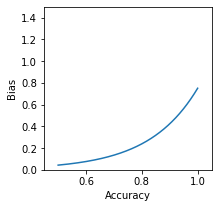

In [16]:
analysis_report(create_adult_dataset, data)

### Compas Dataset

Dataset Name: compas               11 features, 9388 rows

Target Value Distribution:
	Value: 0                    Percent: 0.6605%
	Value: 1                    Percent: 0.3395%

Protected Attribute: race
Protected Value Distribution:
	Value: African-American     Percent: 0.4977%
	Value: Caucasian            Percent: 0.3465%
	Value: Hispanic             Percent: 0.0870%
	Value: Other                Percent: 0.0608%
	Value: Asian                Percent: 0.0051%
	Value: Native American      Percent: 0.0029%

Correlations with Target:
	Feature: _TARGET_                       Corr: 1.0000
	Feature: priors_count                   Corr: 0.2635
	Feature: age                            Corr: -0.1534
	Feature: race                           Corr: -0.1294
	Feature: juv_other_count                Corr: 0.1070
	Feature: juv_misd_count                 Corr: 0.1048
	Feature: sex                            Corr: 0.0997
	Feature: c_charge_degree                Corr: -0.0795
	Feature: juv_fel_count    

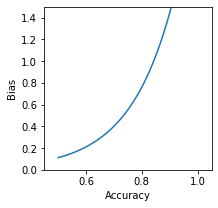

In [17]:
analysis_report(create_compas_dataset, data)

### Communities Dataset

Dataset Name: communities          97 features, 1993 rows

Target Value Distribution:
	Value: 0                    Percent: 0.6448%
	Value: 1                    Percent: 0.3552%

Protected Attribute: race_c
Protected Value Distribution:
	Value: white                Percent: 0.7888%
	Value: black                Percent: 0.1094%
	Value: hispanic             Percent: 0.0577%
	Value: asian                Percent: 0.0442%

Correlations with Target:
	Feature: _TARGET_                       Corr: 1.0000
	Feature: PctKids2Par                    Corr: -0.6396
	Feature: PctIlleg                       Corr: 0.6290
	Feature: PctFam2Par                     Corr: -0.6031
	Feature: PctYoungKids2Par               Corr: -0.5803
	Feature: PctTeen2Par                    Corr: -0.5536
	Feature: pctWInvInc                     Corr: -0.5480
	Feature: pctWPubAsst                    Corr: 0.5432
	Feature: FemalePctDiv                   Corr: 0.5008
	Feature: PctPopUnderPov                 Corr: 0.4959
	Featur

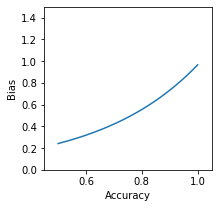

In [18]:
analysis_report(create_communities_dataset, data)

### Titanic Dataset

Dataset Name: titanic              7 features, 712 rows

Target Value Distribution:
	Value: 0                    Percent: 0.5955%
	Value: 1                    Percent: 0.4045%

Protected Attribute: Sex
Protected Value Distribution:
	Value: male                 Percent: 0.6362%
	Value: female               Percent: 0.3638%

Correlations with Target:
	Feature: _TARGET_                       Corr: 1.0000
	Feature: Sex                            Corr: -0.5368
	Feature: Pclass                         Corr: -0.3565
	Feature: Fare                           Corr: 0.2661
	Feature: Embarked                       Corr: -0.1820
	Feature: Parch                          Corr: 0.0953
	Feature: Age                            Corr: -0.0824
	Feature: SibSp                          Corr: -0.0155

Correlations with Protected:
	Feature: Sex                            Corr: 1.0000
	Feature: _TARGET_                       Corr: -0.5368
	Feature: Parch                          Corr: -0.2495
	Feature: Fare    

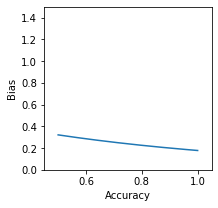

In [19]:
analysis_report(create_titanic_dataset, data)

### Germen Credit Dataset

Dataset Name: german               20 features, 1000 rows

Target Value Distribution:
	Value: 0                    Percent: 0.7000%
	Value: 1                    Percent: 0.3000%

Protected Attribute: Age
Protected Value Distribution:
	Value: elder                Percent: 0.8100%
	Value: young                Percent: 0.1900%

Correlations with Target:
	Feature: _TARGET_                       Corr: 1.0000
	Feature: Status_account                 Corr: -0.3508
	Feature: Credit_history                 Corr: -0.2288
	Feature: Duration_month                 Corr: 0.2149
	Feature: Savings_account                Corr: -0.1789
	Feature: Credit_amount                  Corr: 0.1547
	Feature: Property                       Corr: 0.1426
	Feature: Age                            Corr: 0.1279
	Feature: Employment_since               Corr: -0.1160
	Feature: Installment_plans              Corr: -0.1098
	Feature: Personal_status                Corr: -0.0882
	Feature: Foreign                        Corr: 

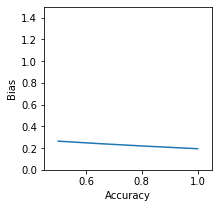

In [20]:
analysis_report(create_german_dataset, data)

### Bank Dataset

Dataset Name: bank                 16 features, 45211 rows

Target Value Distribution:
	Value: 0                    Percent: 0.8830%
	Value: 1                    Percent: 0.1170%

Protected Attribute: age
Protected Value Distribution:
	Value: elder                Percent: 0.6679%
	Value: young                Percent: 0.3321%

Correlations with Target:
	Feature: _TARGET_                       Corr: 1.0000
	Feature: duration                       Corr: 0.3945
	Feature: contact                        Corr: -0.1484
	Feature: housing                        Corr: -0.1392
	Feature: pdays                          Corr: 0.1036
	Feature: previous                       Corr: 0.0932
	Feature: poutcome                       Corr: -0.0778
	Feature: campaign                       Corr: -0.0732
	Feature: loan                           Corr: -0.0682
	Feature: education                      Corr: 0.0662
	Feature: balance                        Corr: 0.0528
	Feature: marital                        Corr: 

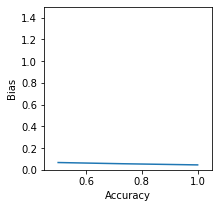

In [21]:
analysis_report(create_bank_dataset, data)

### Analysis 

A larger bias on start requires:  
* Protected attribute and Target has high correlation  
* Other (or some) features has high correlation with Protected attribute  

Reason for Bias reduction after MCAR and Imputation methods:  
* MCAR brings missing values randomly  
* Imputation fills missing values with values that mitigate the differences (especially in V2)  

Why no bias reduction?
1. Bias on start is low (not biased data)  
2. Data used to fill missing values increase (or doesn't change) the differences  

What data is used for each Imputation method?  
* _Mean Imputation_: averaged value for each feature, features are not affecting each other  
* _Similar Imputation_: similar data rows, all features are taken into account when deciding similarity  
* _Multiple Imputation_: iterative prediction, all features are taken into account, new values generated  